In [68]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sarscov/Virat-4.jpg
/kaggle/input/sarscov/Covid_new_data/test/COVID/Covid (99).png
/kaggle/input/sarscov/Covid_new_data/test/COVID/Covid (251).png
/kaggle/input/sarscov/Covid_new_data/test/COVID/Covid (740).png
/kaggle/input/sarscov/Covid_new_data/test/COVID/Covid (817).png
/kaggle/input/sarscov/Covid_new_data/test/COVID/Covid (100).png
/kaggle/input/sarscov/Covid_new_data/test/COVID/Covid (1140).png
/kaggle/input/sarscov/Covid_new_data/test/COVID/Covid (94).png
/kaggle/input/sarscov/Covid_new_data/test/COVID/Covid (856).png
/kaggle/input/sarscov/Covid_new_data/test/COVID/Covid (64).png
/kaggle/input/sarscov/Covid_new_data/test/COVID/Covid (962).png
/kaggle/input/sarscov/Covid_new_data/test/COVID/Covid (1204).png
/kaggle/input/sarscov/Covid_new_data/test/COVID/Covid (1174).png
/kaggle/input/sarscov/Covid_new_data/test/COVID/Covid (914).png
/kaggle/input/sarscov/Covid_new_data/test/COVID/Covid (485).png
/kaggle/input/sarscov/Covid_new_data/test/COVID/Covid (670).png
/kaggl

/kaggle/input/sarscov/Covid_new_data/train/non-COVID/Non-Covid (883).png
/kaggle/input/sarscov/Covid_new_data/train/non-COVID/Non-Covid (669).png
/kaggle/input/sarscov/Covid_new_data/train/non-COVID/Non-Covid (41).png
/kaggle/input/sarscov/Covid_new_data/train/non-COVID/Non-Covid (1070).png
/kaggle/input/sarscov/Covid_new_data/train/non-COVID/Non-Covid (441).png
/kaggle/input/sarscov/Covid_new_data/train/non-COVID/Non-Covid (138).png
/kaggle/input/sarscov/Covid_new_data/train/non-COVID/Non-Covid (309).png
/kaggle/input/sarscov/Covid_new_data/train/non-COVID/Non-Covid (158).png
/kaggle/input/sarscov/Covid_new_data/train/non-COVID/Non-Covid (712).png
/kaggle/input/sarscov/Covid_new_data/train/non-COVID/Non-Covid (1122).png
/kaggle/input/sarscov/Covid_new_data/train/non-COVID/Non-Covid (1048).png
/kaggle/input/sarscov/Covid_new_data/train/non-COVID/Non-Covid (950).png
/kaggle/input/sarscov/Covid_new_data/train/non-COVID/Non-Covid (1125).png
/kaggle/input/sarscov/Covid_new_data/train/non-C

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, ModelCheckpoint
from keras.applications import *
import tensorflow as tf

In [70]:
image_width=224
image_height=224
no_of_channels=3
input_shape=(image_width,image_height,no_of_channels)

In [71]:
#FEEDING DATA INTO THE MODEL
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

#class for training set
train_data = ImageDataGenerator(rescale = 1./255)

#class for test set
test_data = ImageDataGenerator(rescale = 1./255)


train_data_dir = '../input/sarscov/Covid_new_data/train'
test_data_dir = '../input/sarscov/Covid_new_data/test'
batch_size = 32

train_set = train_data.flow_from_directory(train_data_dir, #Image path
                                           target_size = (224,224), #The shape which we want to input our images in our model
                                           batch_size = batch_size,         #The batch size in mini batch gradient descent
                                           class_mode = 'categorical', shuffle=True) 
test_set = test_data.flow_from_directory(test_data_dir, #Image path
                                           target_size = (224,224), #The shape which we want to input our images in our model
                                           batch_size = batch_size,         #The batch size in mini batch gradient descent
                                           class_mode = 'categorical', shuffle=False)  

Found 1984 images belonging to 2 classes.
Found 497 images belonging to 2 classes.


In [72]:
COUNT_TRAIN_COVID = len(os.listdir('../input/sarscov/Covid_new_data/train/COVID'))
COUNT_TRAIN_NONCOVID = len(os.listdir('../input/sarscov/Covid_new_data/train/non-COVID'))
TRAIN_IMG_COUNT = COUNT_TRAIN_NONCOVID + COUNT_TRAIN_COVID
print('Train images: ',TRAIN_IMG_COUNT)
initial_bias = np.log([COUNT_TRAIN_COVID/COUNT_TRAIN_NONCOVID])
print(initial_bias)

weight_for_0 = (1 / COUNT_TRAIN_COVID)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_TRAIN_NONCOVID)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}
print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))


Train images:  1984
[0.01814566]
Weight for class 0: 0.99
Weight for class 1: 1.01


In [73]:
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.1,
                                         patience=5,
                                         cooldown=2,
                                         min_lr=1e-8,
                                         verbose=1)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)

EPOCHS = 100

In [74]:
#VGG-16 MODEL NO. 1
#from tensorflow.keras.applications import VGG16
tmodel_base = VGG16(input_shape = input_shape, 
                                include_top = False, 
                                weights = 'imagenet')
for layer in tmodel_base.layers:
    layer.trainable = False

#Getting desired layer output
last_layer = tmodel_base.get_layer('block5_pool')
last = last_layer.output

x = Flatten()(last)
x = Dense(1028, activation = 'relu')(x)
x = Dropout(rate = 0.15)(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(rate = 0.25)(x)
x = Dense(2, activation = 'softmax')(x)
# Modification of pretrained mode

#Compiling model
model1 = Model(inputs = tmodel_base.input, outputs = x, name = 'VGG16')
opt1 = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999)
#opt2 = RMSprop(learning_rate = 0.001)


model1.compile(optimizer = opt1 , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model1.summary()

Model: "VGG16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [75]:
# Fits the model on batches with real-time data augmentation
vgg_checkpoint = ModelCheckpoint("vgg_best.h5", monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

history_vgg = model1.fit(train_set,  epochs=EPOCHS, validation_data = test_set
                       ,class_weight=class_weight ,callbacks=[vgg_checkpoint])

Epoch 1/100
62/62 [==============================] - ETA: 0s - loss: 0.5605 - accuracy: 0.6996
Epoch 00001: val_loss improved from inf to 0.35970, saving model to vgg_best.h5
62/62 [==============================] - 17s 270ms/step - loss: 0.5605 - accuracy: 0.6996 - val_loss: 0.3597 - val_accuracy: 0.8511
Epoch 2/100
62/62 [==============================] - ETA: 0s - loss: 0.3678 - accuracy: 0.8387
Epoch 00002: val_loss improved from 0.35970 to 0.25536, saving model to vgg_best.h5
62/62 [==============================] - 16s 257ms/step - loss: 0.3678 - accuracy: 0.8387 - val_loss: 0.2554 - val_accuracy: 0.9095
Epoch 3/100
62/62 [==============================] - ETA: 0s - loss: 0.2765 - accuracy: 0.8876
Epoch 00003: val_loss improved from 0.25536 to 0.21197, saving model to vgg_best.h5
62/62 [==============================] - 16s 251ms/step - loss: 0.2765 - accuracy: 0.8876 - val_loss: 0.2120 - val_accuracy: 0.9195
Epoch 4/100
62/62 [==============================] - ETA: 0s - loss: 0.

62/62 [==============================] - ETA: 0s - loss: 0.0076 - accuracy: 1.0000
Epoch 00028: val_loss did not improve from 0.05408
62/62 [==============================] - 14s 230ms/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.0554 - val_accuracy: 0.9819
Epoch 29/100
62/62 [==============================] - ETA: 0s - loss: 0.0071 - accuracy: 1.0000
Epoch 00029: val_loss did not improve from 0.05408
62/62 [==============================] - 14s 229ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.0545 - val_accuracy: 0.9839
Epoch 30/100
62/62 [==============================] - ETA: 0s - loss: 0.0061 - accuracy: 1.0000
Epoch 00030: val_loss did not improve from 0.05408
62/62 [==============================] - 14s 228ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.0541 - val_accuracy: 0.9819
Epoch 31/100
62/62 [==============================] - ETA: 0s - loss: 0.0062 - accuracy: 1.0000
Epoch 00031: val_loss improved from 0.05408 to 0.05353, saving model to vgg_best

Epoch 57/100
62/62 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000
Epoch 00057: val_loss did not improve from 0.04969
62/62 [==============================] - 14s 231ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0610 - val_accuracy: 0.9819
Epoch 58/100
62/62 [==============================] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000
Epoch 00058: val_loss did not improve from 0.04969
62/62 [==============================] - 14s 224ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0539 - val_accuracy: 0.9859
Epoch 59/100
62/62 [==============================] - ETA: 0s - loss: 9.2246e-04 - accuracy: 1.0000
Epoch 00059: val_loss did not improve from 0.04969
62/62 [==============================] - 14s 228ms/step - loss: 9.2246e-04 - accuracy: 1.0000 - val_loss: 0.0512 - val_accuracy: 0.9839
Epoch 60/100
62/62 [==============================] - ETA: 0s - loss: 8.5100e-04 - accuracy: 1.0000
Epoch 00060: val_loss did not improve from 0.04969
62/6

Epoch 86/100
62/62 [==============================] - ETA: 0s - loss: 2.4868e-04 - accuracy: 1.0000
Epoch 00086: val_loss did not improve from 0.04969
62/62 [==============================] - 15s 236ms/step - loss: 2.4868e-04 - accuracy: 1.0000 - val_loss: 0.0553 - val_accuracy: 0.9879
Epoch 87/100
62/62 [==============================] - ETA: 0s - loss: 2.2274e-04 - accuracy: 1.0000
Epoch 00087: val_loss did not improve from 0.04969
62/62 [==============================] - 14s 226ms/step - loss: 2.2274e-04 - accuracy: 1.0000 - val_loss: 0.0544 - val_accuracy: 0.9859
Epoch 88/100
62/62 [==============================] - ETA: 0s - loss: 2.1378e-04 - accuracy: 1.0000
Epoch 00088: val_loss did not improve from 0.04969
62/62 [==============================] - 14s 223ms/step - loss: 2.1378e-04 - accuracy: 1.0000 - val_loss: 0.0559 - val_accuracy: 0.9859
Epoch 89/100
62/62 [==============================] - ETA: 0s - loss: 1.8934e-04 - accuracy: 1.0000
Epoch 00089: val_loss did not improve f

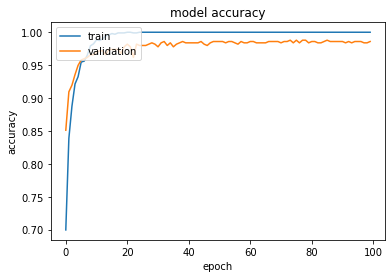

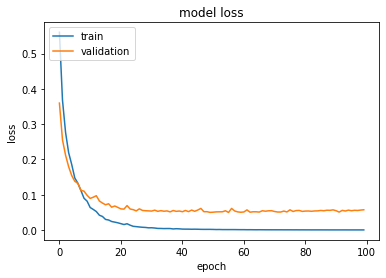

In [76]:
#  "Accuracy"
history1 = history_vgg
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [77]:
#Xception MODEL NO. 1
#from tensorflow.keras.applications import Xception
tmodel_base = Xception(input_shape = input_shape, 
                                include_top = False, 
                                weights = 'imagenet')
for layer in tmodel_base.layers:
    layer.trainable = False

#Getting desired layer output
# Modification of pretrained model
last_layer = tmodel_base.get_layer('block14_sepconv2_act')
last_output = last_layer.output
 
#x = GlobalMaxPooling2D()(last_output)
x = MaxPooling2D(strides=(2,2))(last_output)
x = Flatten()(x)
#x = Dense(1024,activation='relu')(x)
#x = Dropout(0.15)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.15)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.15)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(2, activation='softmax')(x)
#Compiling model
model2 = Model(inputs = tmodel_base.input, outputs = x, name = 'Our_Xception')
model2.summary()


Model: "Our_Xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_12[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [78]:
opt1 = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999)
#opt2 = RMSprop(learning_rate = 0.001)
xception_checkpoint = ModelCheckpoint("xception_best.h5", monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

model2.compile(optimizer = opt1 , loss = 'categorical_crossentropy', metrics = ['accuracy'])

history2 = model2.fit(train_set, epochs=EPOCHS, validation_data = test_set
                     ,class_weight=class_weight ,callbacks=[ xception_checkpoint])

Epoch 1/100
62/62 [==============================] - ETA: 0s - loss: 0.6941 - accuracy: 0.5978
Epoch 00001: val_loss improved from inf to 0.53256, saving model to xception_best.h5
62/62 [==============================] - 16s 251ms/step - loss: 0.6941 - accuracy: 0.5978 - val_loss: 0.5326 - val_accuracy: 0.7565
Epoch 2/100
62/62 [==============================] - ETA: 0s - loss: 0.5256 - accuracy: 0.7369
Epoch 00002: val_loss improved from 0.53256 to 0.44037, saving model to xception_best.h5
62/62 [==============================] - 16s 261ms/step - loss: 0.5256 - accuracy: 0.7369 - val_loss: 0.4404 - val_accuracy: 0.8008
Epoch 3/100
62/62 [==============================] - ETA: 0s - loss: 0.4380 - accuracy: 0.8029
Epoch 00003: val_loss improved from 0.44037 to 0.37739, saving model to xception_best.h5
62/62 [==============================] - 15s 241ms/step - loss: 0.4380 - accuracy: 0.8029 - val_loss: 0.3774 - val_accuracy: 0.8310
Epoch 4/100
62/62 [==============================] - ETA

Epoch 28/100
62/62 [==============================] - ETA: 0s - loss: 0.0292 - accuracy: 0.9970
Epoch 00028: val_loss did not improve from 0.15357
62/62 [==============================] - 14s 232ms/step - loss: 0.0292 - accuracy: 0.9970 - val_loss: 0.1599 - val_accuracy: 0.9416
Epoch 29/100
62/62 [==============================] - ETA: 0s - loss: 0.0279 - accuracy: 0.9965
Epoch 00029: val_loss did not improve from 0.15357
62/62 [==============================] - 15s 243ms/step - loss: 0.0279 - accuracy: 0.9965 - val_loss: 0.1544 - val_accuracy: 0.9457
Epoch 30/100
62/62 [==============================] - ETA: 0s - loss: 0.0300 - accuracy: 0.9940
Epoch 00030: val_loss did not improve from 0.15357
62/62 [==============================] - 15s 236ms/step - loss: 0.0300 - accuracy: 0.9940 - val_loss: 0.1553 - val_accuracy: 0.9457
Epoch 31/100
62/62 [==============================] - ETA: 0s - loss: 0.0252 - accuracy: 0.9965
Epoch 00031: val_loss improved from 0.15357 to 0.15159, saving mode

62/62 [==============================] - ETA: 0s - loss: 0.0071 - accuracy: 1.0000
Epoch 00057: val_loss did not improve from 0.14863
62/62 [==============================] - 15s 244ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.1665 - val_accuracy: 0.9457
Epoch 58/100
62/62 [==============================] - ETA: 0s - loss: 0.0047 - accuracy: 1.0000
Epoch 00058: val_loss did not improve from 0.14863
62/62 [==============================] - 15s 238ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.1797 - val_accuracy: 0.9416
Epoch 59/100
62/62 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 1.0000
Epoch 00059: val_loss did not improve from 0.14863
62/62 [==============================] - 14s 231ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.1853 - val_accuracy: 0.9396
Epoch 60/100
62/62 [==============================] - ETA: 0s - loss: 0.0064 - accuracy: 0.9990
Epoch 00060: val_loss did not improve from 0.14863
62/62 [======================

Epoch 87/100
62/62 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000
Epoch 00087: val_loss did not improve from 0.14863
62/62 [==============================] - 14s 227ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.1775 - val_accuracy: 0.9557
Epoch 88/100
62/62 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000
Epoch 00088: val_loss did not improve from 0.14863
62/62 [==============================] - 14s 233ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.1717 - val_accuracy: 0.9517
Epoch 89/100
62/62 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000
Epoch 00089: val_loss did not improve from 0.14863
62/62 [==============================] - 15s 249ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.1889 - val_accuracy: 0.9497
Epoch 90/100
62/62 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000
Epoch 00090: val_loss did not improve from 0.14863
62/62 [=========

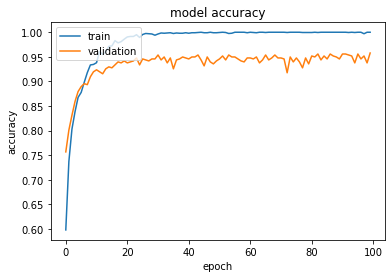

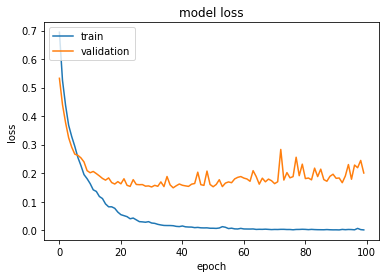

In [79]:
#  "Accuracy"
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [80]:
#ResNet50 MODEL NO. 3
from tensorflow.keras.applications.resnet50 import ResNet50
num_classes=1
tmodel_base = ResNet50(input_shape = input_shape, 
                                include_top = False, 
                                weights = 'imagenet')
for layer in tmodel_base.layers:
    layer.trainable = False

#last_layer = tmodel_base.get_layer('flatten_13')
last = tmodel_base.output


x = Conv2D(1024,(2,2),strides=(1,1))(last)
#x = layers.GlobalMaxPooling2D()(last)
x = Flatten()(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(rate = 0.15)(x)
x = Dense(256, activation = 'relu')(x)
x = Dropout(rate = 0.25)(x)
x = Dense(2, activation = 'softmax')(x)

#Compiling model
model3 = Model(inputs = tmodel_base.input, outputs = x)
model3.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_13[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________

In [81]:
opt1 = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999)
#opt2 = RMSprop(learning_rate = 0.001)
resnet_checkpoint = ModelCheckpoint("resnetbest.h5", monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

model3.compile(optimizer = opt1 , loss = 'categorical_crossentropy', metrics = ['accuracy'])
history3 = model3.fit(train_set,epochs=EPOCHS, validation_data = test_set
                      ,class_weight=class_weight ,callbacks=[resnet_checkpoint])


Epoch 1/100
62/62 [==============================] - ETA: 0s - loss: 1.4104 - accuracy: 0.5247
Epoch 00001: val_loss improved from inf to 0.62247, saving model to resnetbest.h5
62/62 [==============================] - 18s 291ms/step - loss: 1.4104 - accuracy: 0.5247 - val_loss: 0.6225 - val_accuracy: 0.6861
Epoch 2/100
62/62 [==============================] - ETA: 0s - loss: 0.6672 - accuracy: 0.6069
Epoch 00002: val_loss improved from 0.62247 to 0.58278, saving model to resnetbest.h5
62/62 [==============================] - 16s 255ms/step - loss: 0.6672 - accuracy: 0.6069 - val_loss: 0.5828 - val_accuracy: 0.7082
Epoch 3/100
62/62 [==============================] - ETA: 0s - loss: 0.6404 - accuracy: 0.6295
Epoch 00003: val_loss did not improve from 0.58278
62/62 [==============================] - 15s 241ms/step - loss: 0.6404 - accuracy: 0.6295 - val_loss: 0.6614 - val_accuracy: 0.5533
Epoch 4/100
62/62 [==============================] - ETA: 0s - loss: 0.6609 - accuracy: 0.6174
Epoch

Epoch 29/100
62/62 [==============================] - ETA: 0s - loss: 0.1602 - accuracy: 0.9269
Epoch 00029: val_loss did not improve from 0.18865
62/62 [==============================] - 15s 238ms/step - loss: 0.1602 - accuracy: 0.9269 - val_loss: 0.1901 - val_accuracy: 0.9135
Epoch 30/100
62/62 [==============================] - ETA: 0s - loss: 0.1408 - accuracy: 0.9441
Epoch 00030: val_loss improved from 0.18865 to 0.17924, saving model to resnetbest.h5
62/62 [==============================] - 17s 267ms/step - loss: 0.1408 - accuracy: 0.9441 - val_loss: 0.1792 - val_accuracy: 0.9235
Epoch 31/100
62/62 [==============================] - ETA: 0s - loss: 0.1220 - accuracy: 0.9481
Epoch 00031: val_loss improved from 0.17924 to 0.15957, saving model to resnetbest.h5
62/62 [==============================] - 17s 267ms/step - loss: 0.1220 - accuracy: 0.9481 - val_loss: 0.1596 - val_accuracy: 0.9356
Epoch 32/100
62/62 [==============================] - ETA: 0s - loss: 0.1204 - accuracy: 0.94

Epoch 58/100
62/62 [==============================] - ETA: 0s - loss: 0.0268 - accuracy: 0.9894
Epoch 00058: val_loss did not improve from 0.14528
62/62 [==============================] - 15s 241ms/step - loss: 0.0268 - accuracy: 0.9894 - val_loss: 0.1554 - val_accuracy: 0.9537
Epoch 59/100
62/62 [==============================] - ETA: 0s - loss: 0.0225 - accuracy: 0.9945
Epoch 00059: val_loss did not improve from 0.14528
62/62 [==============================] - 14s 227ms/step - loss: 0.0225 - accuracy: 0.9945 - val_loss: 0.1911 - val_accuracy: 0.9457
Epoch 60/100
62/62 [==============================] - ETA: 0s - loss: 0.0241 - accuracy: 0.9904
Epoch 00060: val_loss did not improve from 0.14528
62/62 [==============================] - 15s 237ms/step - loss: 0.0241 - accuracy: 0.9904 - val_loss: 0.1993 - val_accuracy: 0.9457
Epoch 61/100
62/62 [==============================] - ETA: 0s - loss: 0.0597 - accuracy: 0.9763
Epoch 00061: val_loss did not improve from 0.14528
62/62 [=========

62/62 [==============================] - ETA: 0s - loss: 0.0146 - accuracy: 0.9945
Epoch 00087: val_loss did not improve from 0.13193
62/62 [==============================] - 14s 233ms/step - loss: 0.0146 - accuracy: 0.9945 - val_loss: 0.1662 - val_accuracy: 0.9618
Epoch 88/100
62/62 [==============================] - ETA: 0s - loss: 0.0155 - accuracy: 0.9950
Epoch 00088: val_loss did not improve from 0.13193
62/62 [==============================] - 15s 237ms/step - loss: 0.0155 - accuracy: 0.9950 - val_loss: 0.2043 - val_accuracy: 0.9477
Epoch 89/100
62/62 [==============================] - ETA: 0s - loss: 0.1097 - accuracy: 0.9612
Epoch 00089: val_loss did not improve from 0.13193
62/62 [==============================] - 14s 227ms/step - loss: 0.1097 - accuracy: 0.9612 - val_loss: 0.3171 - val_accuracy: 0.9195
Epoch 90/100
62/62 [==============================] - ETA: 0s - loss: 0.1509 - accuracy: 0.9415
Epoch 00090: val_loss did not improve from 0.13193
62/62 [======================

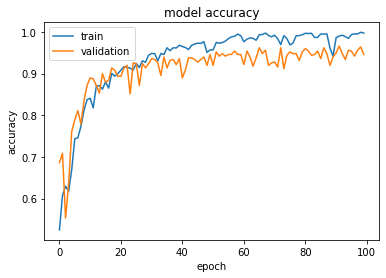

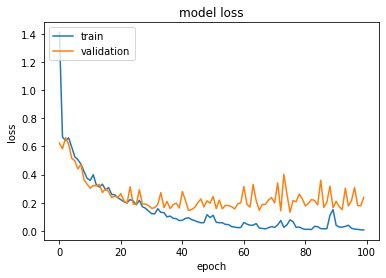

In [82]:
#  "Accuracy"
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**Ensemble**
--

In [83]:
our_vgg = tf.keras.models.load_model('vgg_best.h5')
our_xcep = tf.keras.models.load_model('xception_best.h5')
our_resnet = tf.keras.models.load_model('resnetbest.h5')


print(our_vgg.evaluate(test_set))
print(our_xcep.evaluate(test_set))
print(our_resnet.evaluate(test_set))


16/16 [==============================] - 3s 165ms/step - loss: 0.0497 - accuracy: 0.9839
[0.04968632385134697, 0.9839034080505371]
16/16 [==============================] - 3s 162ms/step - loss: 0.1486 - accuracy: 0.9457
[0.14862537384033203, 0.9456740617752075]
16/16 [==============================] - 3s 159ms/step - loss: 0.1319 - accuracy: 0.9517
[0.13192960619926453, 0.9517102837562561]


In [84]:
our_vgg.trainable = False
our_resnet.trainable = False
our_xcep.trainable = False

In [85]:
def stacking_ensemble(members,input_shape,n_classes):
    commonInput = Input(shape=input_shape)
    out=[]

    for model in members:    
       #model._name= model._name+"test"+ str(members.index(model)+1)
        model._name= model.get_layer(index = 0)._name +"-test"+ str(members.index(model)+1)
        out.append(model(commonInput))

    modeltmp = concatenate(out,axis=-1)
    modeltmp = Dense(64, activation='relu')(modeltmp)
    #modeltmp = Dense(128, activation='relu')(modeltmp)
    modeltmp = Dense(n_classes, activation='softmax')(modeltmp)
    stacked_model = Model(commonInput,modeltmp)
    stacked_model.compile( loss='categorical_crossentropy',optimizer= optimizer, metrics=['accuracy'])

    return stacked_model


In [86]:
reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                         factor=0.1,
                                       patience=4,
                                         cooldown=2,
                                         min_lr=1e-8,
                                         verbose=1)


**VGG16 + ResNet50**
--

In [87]:
members =[our_vgg, our_resnet]

n_classes=2
epochs= 100
batch=32
optimizer= Adam(lr=5e-5, beta_1=0.9, beta_2=0.999)

vgg_res = stacking_ensemble(members,(image_height,image_width,3),n_classes)

In [88]:
#generator=MultipleInputGenerator(X_train,X_train,y_train,batch)
vgg_res_checkpoint = ModelCheckpoint("vgg_res_best.h5", monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

vgg_res_hist = vgg_res.fit(train_set,
                            epochs=100, #epochs,
                            verbose=1,
                            validation_data= test_set,
                            class_weight = class_weight,
                            callbacks=[reduce_learning_rate, vgg_res_checkpoint]) #

Epoch 1/100
62/62 [==============================] - ETA: 0s - loss: 0.6781 - accuracy: 0.5045
Epoch 00001: val_loss improved from inf to 0.66150, saving model to vgg_res_best.h5
62/62 [==============================] - 18s 296ms/step - loss: 0.6781 - accuracy: 0.5045 - val_loss: 0.6615 - val_accuracy: 0.5050
Epoch 2/100
62/62 [==============================] - ETA: 0s - loss: 0.6399 - accuracy: 0.7520
Epoch 00002: val_loss improved from 0.66150 to 0.62619, saving model to vgg_res_best.h5
62/62 [==============================] - 16s 263ms/step - loss: 0.6399 - accuracy: 0.7520 - val_loss: 0.6262 - val_accuracy: 0.9296
Epoch 3/100
62/62 [==============================] - ETA: 0s - loss: 0.6040 - accuracy: 0.9783
Epoch 00003: val_loss improved from 0.62619 to 0.59261, saving model to vgg_res_best.h5
62/62 [==============================] - 17s 272ms/step - loss: 0.6040 - accuracy: 0.9783 - val_loss: 0.5926 - val_accuracy: 0.9477
Epoch 4/100
62/62 [==============================] - ETA: 0

Epoch 27/100
62/62 [==============================] - ETA: 0s - loss: 0.1279 - accuracy: 1.0000
Epoch 00027: val_loss improved from 0.15903 to 0.15144, saving model to vgg_res_best.h5
62/62 [==============================] - 17s 273ms/step - loss: 0.1279 - accuracy: 1.0000 - val_loss: 0.1514 - val_accuracy: 0.9819
Epoch 28/100
62/62 [==============================] - ETA: 0s - loss: 0.1210 - accuracy: 1.0000
Epoch 00028: val_loss improved from 0.15144 to 0.14438, saving model to vgg_res_best.h5
62/62 [==============================] - 18s 287ms/step - loss: 0.1210 - accuracy: 1.0000 - val_loss: 0.1444 - val_accuracy: 0.9819
Epoch 29/100
62/62 [==============================] - ETA: 0s - loss: 0.1122 - accuracy: 1.0000
Epoch 00029: val_loss improved from 0.14438 to 0.13781, saving model to vgg_res_best.h5
62/62 [==============================] - 17s 271ms/step - loss: 0.1122 - accuracy: 1.0000 - val_loss: 0.1378 - val_accuracy: 0.9819
Epoch 30/100
62/62 [==============================] 

Epoch 53/100
62/62 [==============================] - ETA: 0s - loss: 0.0306 - accuracy: 1.0000
Epoch 00053: val_loss improved from 0.06437 to 0.06308, saving model to vgg_res_best.h5
62/62 [==============================] - 17s 272ms/step - loss: 0.0306 - accuracy: 1.0000 - val_loss: 0.0631 - val_accuracy: 0.9859
Epoch 54/100
62/62 [==============================] - ETA: 0s - loss: 0.0290 - accuracy: 1.0000
Epoch 00054: val_loss improved from 0.06308 to 0.06186, saving model to vgg_res_best.h5
62/62 [==============================] - 17s 277ms/step - loss: 0.0290 - accuracy: 1.0000 - val_loss: 0.0619 - val_accuracy: 0.9879
Epoch 55/100
62/62 [==============================] - ETA: 0s - loss: 0.0274 - accuracy: 1.0000
Epoch 00055: val_loss improved from 0.06186 to 0.06075, saving model to vgg_res_best.h5
62/62 [==============================] - 17s 279ms/step - loss: 0.0274 - accuracy: 1.0000 - val_loss: 0.0607 - val_accuracy: 0.9879
Epoch 56/100
62/62 [==============================] 

Epoch 79/100
62/62 [==============================] - ETA: 0s - loss: 0.0096 - accuracy: 1.0000
Epoch 00079: val_loss improved from 0.04772 to 0.04751, saving model to vgg_res_best.h5
62/62 [==============================] - 18s 291ms/step - loss: 0.0096 - accuracy: 1.0000 - val_loss: 0.0475 - val_accuracy: 0.9859
Epoch 80/100
62/62 [==============================] - ETA: 0s - loss: 0.0093 - accuracy: 1.0000
Epoch 00080: val_loss improved from 0.04751 to 0.04732, saving model to vgg_res_best.h5
62/62 [==============================] - 18s 282ms/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.0473 - val_accuracy: 0.9859
Epoch 81/100
62/62 [==============================] - ETA: 0s - loss: 0.0089 - accuracy: 1.0000
Epoch 00081: val_loss improved from 0.04732 to 0.04715, saving model to vgg_res_best.h5
62/62 [==============================] - 17s 268ms/step - loss: 0.0089 - accuracy: 1.0000 - val_loss: 0.0471 - val_accuracy: 0.9859
Epoch 82/100
62/62 [==============================] 

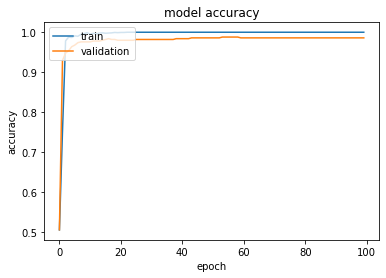

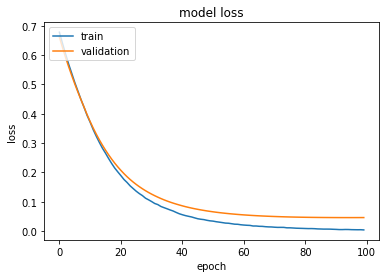

In [89]:
#  "Accuracy"
plt.plot(vgg_res_hist.history['accuracy'])
plt.plot(vgg_res_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(vgg_res_hist.history['loss'])
plt.plot(vgg_res_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**VGG16 + Xception**
--

In [90]:
members =[our_vgg, our_xcep]

n_classes=2
epochs= 100
batch=32
optimizer= Adam(lr=5e-5, beta_1=0.9, beta_2=0.999)

vgg_xcep = stacking_ensemble(members,(image_height,image_width,3),n_classes)


In [91]:
#generator=MultipleInputGenerator(X_train,X_train,y_train,batch)
vgg_xcep_checkpoint = ModelCheckpoint("vgg_xcep_best.h5", monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

vgg_xcep_hist = vgg_xcep.fit(train_set,
                            epochs=100, #epochs,
                            verbose=1,
                            validation_data= test_set,
                            class_weight = class_weight,
                            callbacks=[reduce_learning_rate, vgg_xcep_checkpoint]) #

Epoch 1/100
62/62 [==============================] - ETA: 0s - loss: 0.6118 - accuracy: 0.9990
Epoch 00001: val_loss improved from inf to 0.59932, saving model to vgg_xcep_best.h5
62/62 [==============================] - 18s 289ms/step - loss: 0.6118 - accuracy: 0.9990 - val_loss: 0.5993 - val_accuracy: 0.9799
Epoch 2/100
62/62 [==============================] - ETA: 0s - loss: 0.5768 - accuracy: 1.0000
Epoch 00002: val_loss improved from 0.59932 to 0.56745, saving model to vgg_xcep_best.h5
62/62 [==============================] - 16s 264ms/step - loss: 0.5768 - accuracy: 1.0000 - val_loss: 0.5675 - val_accuracy: 0.9799
Epoch 3/100
62/62 [==============================] - ETA: 0s - loss: 0.5434 - accuracy: 1.0000
Epoch 00003: val_loss improved from 0.56745 to 0.53746, saving model to vgg_xcep_best.h5
62/62 [==============================] - 17s 277ms/step - loss: 0.5434 - accuracy: 1.0000 - val_loss: 0.5375 - val_accuracy: 0.9819
Epoch 4/100
62/62 [==============================] - ETA

Epoch 27/100
62/62 [==============================] - ETA: 0s - loss: 0.1156 - accuracy: 1.0000
Epoch 00027: val_loss improved from 0.15807 to 0.15103, saving model to vgg_xcep_best.h5
62/62 [==============================] - 17s 280ms/step - loss: 0.1156 - accuracy: 1.0000 - val_loss: 0.1510 - val_accuracy: 0.9859
Epoch 28/100
62/62 [==============================] - ETA: 0s - loss: 0.1078 - accuracy: 1.0000
Epoch 00028: val_loss improved from 0.15103 to 0.14454, saving model to vgg_xcep_best.h5
62/62 [==============================] - 17s 281ms/step - loss: 0.1078 - accuracy: 1.0000 - val_loss: 0.1445 - val_accuracy: 0.9859
Epoch 29/100
62/62 [==============================] - ETA: 0s - loss: 0.1015 - accuracy: 1.0000
Epoch 00029: val_loss improved from 0.14454 to 0.13838, saving model to vgg_xcep_best.h5
62/62 [==============================] - 17s 278ms/step - loss: 0.1015 - accuracy: 1.0000 - val_loss: 0.1384 - val_accuracy: 0.9859
Epoch 30/100
62/62 [=============================

Epoch 53/100
62/62 [==============================] - ETA: 0s - loss: 0.0238 - accuracy: 1.0000
Epoch 00053: val_loss improved from 0.06980 to 0.06858, saving model to vgg_xcep_best.h5
62/62 [==============================] - 17s 273ms/step - loss: 0.0238 - accuracy: 1.0000 - val_loss: 0.0686 - val_accuracy: 0.9859
Epoch 54/100
62/62 [==============================] - ETA: 0s - loss: 0.0227 - accuracy: 1.0000
Epoch 00054: val_loss improved from 0.06858 to 0.06746, saving model to vgg_xcep_best.h5
62/62 [==============================] - 17s 276ms/step - loss: 0.0227 - accuracy: 1.0000 - val_loss: 0.0675 - val_accuracy: 0.9859
Epoch 55/100
62/62 [==============================] - ETA: 0s - loss: 0.0216 - accuracy: 1.0000
Epoch 00055: val_loss improved from 0.06746 to 0.06640, saving model to vgg_xcep_best.h5
62/62 [==============================] - 17s 277ms/step - loss: 0.0216 - accuracy: 1.0000 - val_loss: 0.0664 - val_accuracy: 0.9859
Epoch 56/100
62/62 [=============================

Epoch 79/100
62/62 [==============================] - ETA: 0s - loss: 0.0070 - accuracy: 1.0000
Epoch 00079: val_loss improved from 0.05482 to 0.05461, saving model to vgg_xcep_best.h5
62/62 [==============================] - 17s 269ms/step - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.0546 - val_accuracy: 0.9859
Epoch 80/100
62/62 [==============================] - ETA: 0s - loss: 0.0067 - accuracy: 1.0000
Epoch 00080: val_loss improved from 0.05461 to 0.05442, saving model to vgg_xcep_best.h5
62/62 [==============================] - 17s 273ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.0544 - val_accuracy: 0.9859
Epoch 81/100
62/62 [==============================] - ETA: 0s - loss: 0.0062 - accuracy: 1.0000
Epoch 00081: val_loss improved from 0.05442 to 0.05427, saving model to vgg_xcep_best.h5
62/62 [==============================] - 16s 266ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.0543 - val_accuracy: 0.9859
Epoch 82/100
62/62 [=============================

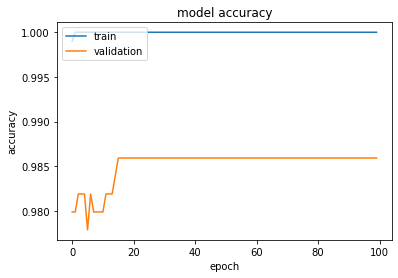

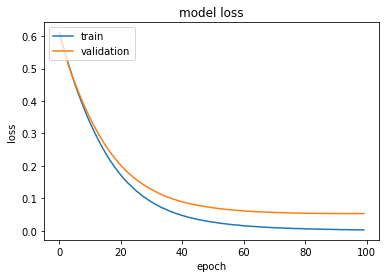

In [92]:
#  "Accuracy"
plt.plot(vgg_xcep_hist.history['accuracy'])
plt.plot(vgg_xcep_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(vgg_xcep_hist.history['loss'])
plt.plot(vgg_xcep_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


**ResNet50 + Xception**
--

In [93]:
members =[our_resnet, our_xcep]

n_classes=2
epochs= 100
batch=32
optimizer= Adam(lr=5e-5, beta_1=0.9, beta_2=0.999)

xcep_res = stacking_ensemble(members,(image_height,image_width,3),n_classes)

In [94]:
#generator=MultipleInputGenerator(X_train,X_train,y_train,batch)
xcep_res_checkpoint = ModelCheckpoint("xcep_res_best.h5", monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

xcep_res_hist = xcep_res.fit(train_set,
                            epochs=100, #epochs,
                            verbose=1,
                            validation_data= test_set,
                            class_weight = class_weight,
                            callbacks=[reduce_learning_rate, xcep_res_checkpoint]) 


Epoch 1/100
62/62 [==============================] - ETA: 0s - loss: 0.7780 - accuracy: 0.4955
Epoch 00001: val_loss improved from inf to 0.76043, saving model to xcep_res_best.h5
62/62 [==============================] - 19s 310ms/step - loss: 0.7780 - accuracy: 0.4955 - val_loss: 0.7604 - val_accuracy: 0.4950
Epoch 2/100
62/62 [==============================] - ETA: 0s - loss: 0.7444 - accuracy: 0.4955
Epoch 00002: val_loss improved from 0.76043 to 0.72955, saving model to xcep_res_best.h5
62/62 [==============================] - 17s 267ms/step - loss: 0.7444 - accuracy: 0.4955 - val_loss: 0.7295 - val_accuracy: 0.4950
Epoch 3/100
62/62 [==============================] - ETA: 0s - loss: 0.7118 - accuracy: 0.4955
Epoch 00003: val_loss improved from 0.72955 to 0.70005, saving model to xcep_res_best.h5
62/62 [==============================] - 18s 289ms/step - loss: 0.7118 - accuracy: 0.4955 - val_loss: 0.7001 - val_accuracy: 0.4950
Epoch 4/100
62/62 [==============================] - ETA

Epoch 27/100
62/62 [==============================] - ETA: 0s - loss: 0.1828 - accuracy: 0.9995
Epoch 00027: val_loss improved from 0.23529 to 0.22467, saving model to xcep_res_best.h5
62/62 [==============================] - 18s 295ms/step - loss: 0.1828 - accuracy: 0.9995 - val_loss: 0.2247 - val_accuracy: 0.9638
Epoch 28/100
62/62 [==============================] - ETA: 0s - loss: 0.1705 - accuracy: 1.0000
Epoch 00028: val_loss improved from 0.22467 to 0.21479, saving model to xcep_res_best.h5
62/62 [==============================] - 18s 295ms/step - loss: 0.1705 - accuracy: 1.0000 - val_loss: 0.2148 - val_accuracy: 0.9638
Epoch 29/100
62/62 [==============================] - ETA: 0s - loss: 0.1626 - accuracy: 0.9990
Epoch 00029: val_loss improved from 0.21479 to 0.20565, saving model to xcep_res_best.h5
62/62 [==============================] - 18s 285ms/step - loss: 0.1626 - accuracy: 0.9990 - val_loss: 0.2057 - val_accuracy: 0.9638
Epoch 30/100
62/62 [=============================

Epoch 53/100
62/62 [==============================] - ETA: 0s - loss: 0.0424 - accuracy: 1.0000
Epoch 00053: val_loss improved from 0.11083 to 0.10934, saving model to xcep_res_best.h5
62/62 [==============================] - 18s 293ms/step - loss: 0.0424 - accuracy: 1.0000 - val_loss: 0.1093 - val_accuracy: 0.9618
Epoch 54/100
62/62 [==============================] - ETA: 0s - loss: 0.0413 - accuracy: 0.9995
Epoch 00054: val_loss improved from 0.10934 to 0.10805, saving model to xcep_res_best.h5
62/62 [==============================] - 17s 278ms/step - loss: 0.0413 - accuracy: 0.9995 - val_loss: 0.1081 - val_accuracy: 0.9618
Epoch 55/100
62/62 [==============================] - ETA: 0s - loss: 0.0387 - accuracy: 0.9995
Epoch 00055: val_loss improved from 0.10805 to 0.10682, saving model to xcep_res_best.h5
62/62 [==============================] - 18s 288ms/step - loss: 0.0387 - accuracy: 0.9995 - val_loss: 0.1068 - val_accuracy: 0.9618
Epoch 56/100
62/62 [=============================

Epoch 79/100
62/62 [==============================] - ETA: 0s - loss: 0.0136 - accuracy: 0.9995
Epoch 00079: val_loss improved from 0.09659 to 0.09649, saving model to xcep_res_best.h5
62/62 [==============================] - 17s 270ms/step - loss: 0.0136 - accuracy: 0.9995 - val_loss: 0.0965 - val_accuracy: 0.9618
Epoch 80/100
62/62 [==============================] - ETA: 0s - loss: 0.0156 - accuracy: 0.9985
Epoch 00080: val_loss did not improve from 0.09649
62/62 [==============================] - 16s 261ms/step - loss: 0.0156 - accuracy: 0.9985 - val_loss: 0.0966 - val_accuracy: 0.9618
Epoch 81/100
62/62 [==============================] - ETA: 0s - loss: 0.0130 - accuracy: 0.9995
Epoch 00081: val_loss did not improve from 0.09649
62/62 [==============================] - 16s 253ms/step - loss: 0.0130 - accuracy: 0.9995 - val_loss: 0.0967 - val_accuracy: 0.9618
Epoch 82/100
62/62 [==============================] - ETA: 0s - loss: 0.0127 - accuracy: 1.0000
Epoch 00082: val_loss did not

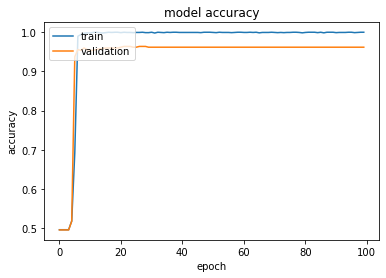

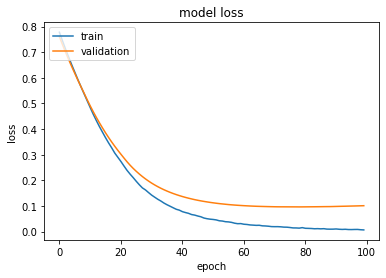

In [95]:
#  "Accuracy"
plt.plot(xcep_res_hist.history['accuracy'])
plt.plot(xcep_res_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(xcep_res_hist.history['loss'])
plt.plot(xcep_res_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**Stacked Model**
--

In [96]:
members =[our_vgg, our_resnet,our_xcep]

n_classes=2
epochs= 100
batch=32
optimizer= Adam(lr=5e-5, beta_1=0.9, beta_2=0.999)

stacked_model = stacking_ensemble(members,(image_height,image_width,3),n_classes)


In [97]:
#generator=MultipleInputGenerator(X_train,X_train,y_train,batch)
stacked_checkpoint = ModelCheckpoint("stacked_best.h5", monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto', period=1)


history = stacked_model.fit(train_set,
                            epochs=EPOCHS, #epochs,
                            verbose=1,
                            validation_data=test_set,
                            class_weight = class_weight,
                            callbacks=[reduce_learning_rate, stacked_checkpoint]) #

Epoch 1/100
62/62 [==============================] - ETA: 0s - loss: 0.8501 - accuracy: 0.0000e+00
Epoch 00001: val_loss improved from inf to 0.82190, saving model to stacked_best.h5
62/62 [==============================] - 21s 334ms/step - loss: 0.8501 - accuracy: 0.0000e+00 - val_loss: 0.8219 - val_accuracy: 0.0322
Epoch 2/100
62/62 [==============================] - ETA: 0s - loss: 0.8002 - accuracy: 0.1215
Epoch 00002: val_loss improved from 0.82190 to 0.77680, saving model to stacked_best.h5
62/62 [==============================] - 20s 315ms/step - loss: 0.8002 - accuracy: 0.1215 - val_loss: 0.7768 - val_accuracy: 0.4205
Epoch 3/100
62/62 [==============================] - ETA: 0s - loss: 0.7535 - accuracy: 0.4904
Epoch 00003: val_loss improved from 0.77680 to 0.73404, saving model to stacked_best.h5
62/62 [==============================] - 18s 297ms/step - loss: 0.7535 - accuracy: 0.4904 - val_loss: 0.7340 - val_accuracy: 0.4849
Epoch 4/100
62/62 [==============================] 

Epoch 27/100
62/62 [==============================] - ETA: 0s - loss: 0.1350 - accuracy: 1.0000
Epoch 00027: val_loss improved from 0.17605 to 0.16637, saving model to stacked_best.h5
62/62 [==============================] - 19s 308ms/step - loss: 0.1350 - accuracy: 1.0000 - val_loss: 0.1664 - val_accuracy: 0.9819
Epoch 28/100
62/62 [==============================] - ETA: 0s - loss: 0.1256 - accuracy: 1.0000
Epoch 00028: val_loss improved from 0.16637 to 0.15751, saving model to stacked_best.h5
62/62 [==============================] - 19s 305ms/step - loss: 0.1256 - accuracy: 1.0000 - val_loss: 0.1575 - val_accuracy: 0.9819
Epoch 29/100
62/62 [==============================] - ETA: 0s - loss: 0.1157 - accuracy: 1.0000
Epoch 00029: val_loss improved from 0.15751 to 0.14937, saving model to stacked_best.h5
62/62 [==============================] - 18s 296ms/step - loss: 0.1157 - accuracy: 1.0000 - val_loss: 0.1494 - val_accuracy: 0.9819
Epoch 30/100
62/62 [==============================] 

Epoch 53/100
62/62 [==============================] - ETA: 0s - loss: 0.0262 - accuracy: 1.0000
Epoch 00053: val_loss improved from 0.06668 to 0.06535, saving model to stacked_best.h5
62/62 [==============================] - 19s 303ms/step - loss: 0.0262 - accuracy: 1.0000 - val_loss: 0.0653 - val_accuracy: 0.9859
Epoch 54/100
62/62 [==============================] - ETA: 0s - loss: 0.0238 - accuracy: 1.0000
Epoch 00054: val_loss improved from 0.06535 to 0.06411, saving model to stacked_best.h5
62/62 [==============================] - 18s 291ms/step - loss: 0.0238 - accuracy: 1.0000 - val_loss: 0.0641 - val_accuracy: 0.9859
Epoch 55/100
62/62 [==============================] - ETA: 0s - loss: 0.0227 - accuracy: 1.0000
Epoch 00055: val_loss improved from 0.06411 to 0.06298, saving model to stacked_best.h5
62/62 [==============================] - 20s 315ms/step - loss: 0.0227 - accuracy: 1.0000 - val_loss: 0.0630 - val_accuracy: 0.9859
Epoch 56/100
62/62 [==============================] 

Epoch 79/100
62/62 [==============================] - ETA: 0s - loss: 0.0075 - accuracy: 0.9995
Epoch 00079: val_loss improved from 0.04975 to 0.04949, saving model to stacked_best.h5
62/62 [==============================] - 19s 302ms/step - loss: 0.0075 - accuracy: 0.9995 - val_loss: 0.0495 - val_accuracy: 0.9859
Epoch 80/100
62/62 [==============================] - ETA: 0s - loss: 0.0073 - accuracy: 0.9995
Epoch 00080: val_loss improved from 0.04949 to 0.04924, saving model to stacked_best.h5
62/62 [==============================] - 19s 303ms/step - loss: 0.0073 - accuracy: 0.9995 - val_loss: 0.0492 - val_accuracy: 0.9859
Epoch 81/100
62/62 [==============================] - ETA: 0s - loss: 0.0066 - accuracy: 1.0000
Epoch 00081: val_loss improved from 0.04924 to 0.04903, saving model to stacked_best.h5
62/62 [==============================] - 19s 299ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.0490 - val_accuracy: 0.9859
Epoch 82/100
62/62 [==============================] 

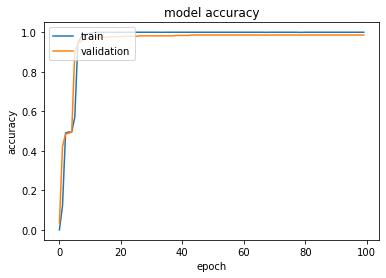

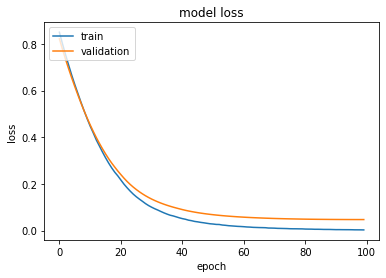

In [98]:
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**Calculation**
--

In [99]:
y_true = test_set.classes

In [100]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report, confusion_matrix

**VGG16**
--

16/16 [==============================] - 3s 169ms/step - loss: 0.0497 - accuracy: 0.9839
Loss:  0.04968632385134697
Accuracy:  0.9839034080505371
Precision, Recall and F1 Score:
(0.9839034205231388, 0.9839034205231388, 0.9839034205231388, None)


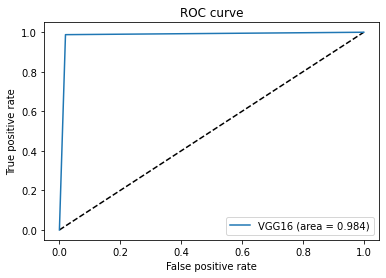

           covid  non-covid
covid        246          5
non-covid      3        243
Classification Report
              precision    recall  f1-score   support

       Covid       0.99      0.98      0.98       251
   Non-covid       0.98      0.99      0.98       246

    accuracy                           0.98       497
   macro avg       0.98      0.98      0.98       497
weighted avg       0.98      0.98      0.98       497



In [101]:
evaluation_vgg = our_vgg.evaluate(test_set)
print('Loss: ',evaluation_vgg[0])
print('Accuracy: ',evaluation_vgg[1])

prob_vgg = our_vgg.predict(test_set)
predictions_vgg = prob_vgg.argmax(axis=-1)

print("Precision, Recall and F1 Score:")
print(precision_recall_fscore_support(y_true, predictions_vgg, average='micro'))

fpr_vgg, tpr_vgg, thresholds_vgg = roc_curve(y_true, predictions_vgg)
auc_vgg = auc(fpr_vgg, tpr_vgg)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_vgg, tpr_vgg, label='VGG16 (area = {:.3f})'.format(auc_vgg))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print(pd.DataFrame(data = confusion_matrix(y_true, predictions_vgg), index = ['covid', 'non-covid'], columns = ['covid', 'non-covid'] ))
print('Classification Report')
target_names = ['Covid', 'Non-covid']
print(classification_report(y_true, predictions_vgg, target_names=target_names))

**ResNet50**
--

16/16 [==============================] - 3s 158ms/step - loss: 0.1319 - accuracy: 0.9517
Loss:  0.13192960619926453
Accuracy:  0.9517102837562561
(0.9517102615694165, 0.9517102615694165, 0.9517102615694165, None)


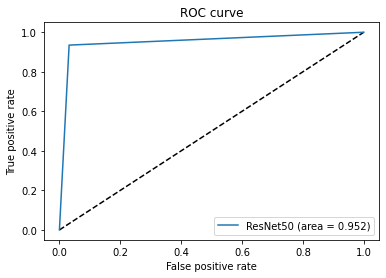

           covid  non-covid
covid        243          8
non-covid     16        230
Classification Report
              precision    recall  f1-score   support

       Covid       0.94      0.97      0.95       251
   Non-covid       0.97      0.93      0.95       246

    accuracy                           0.95       497
   macro avg       0.95      0.95      0.95       497
weighted avg       0.95      0.95      0.95       497



In [102]:
evaluation_res = our_resnet.evaluate(test_set)
print('Loss: ',evaluation_res[0])
print('Accuracy: ',evaluation_res[1])


prob_res = our_resnet.predict(test_set)
predictions_res = prob_res.argmax(axis=-1)
print(precision_recall_fscore_support(y_true, predictions_res, average='micro'))


fpr_res, tpr_res, thresholds_res = roc_curve(y_true, predictions_res)
auc_res = auc(fpr_res, tpr_res)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_res, tpr_res, label='ResNet50 (area = {:.3f})'.format(auc_res))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print(pd.DataFrame(data = confusion_matrix(y_true, predictions_res), index = ['covid', 'non-covid'], columns = ['covid', 'non-covid'] ))
print('Classification Report')
target_names = ['Covid', 'Non-covid']
print(classification_report(y_true, predictions_res, target_names=target_names))


**Xception**
--

16/16 [==============================] - 3s 161ms/step - loss: 0.1486 - accuracy: 0.9457
Loss:  0.14862537384033203
Accuracy:  0.9456740617752075


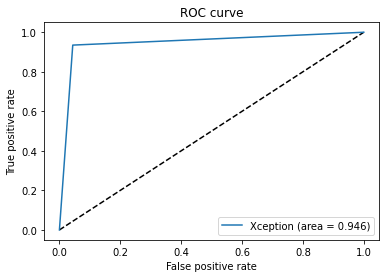

           covid  non-covid
covid        240         11
non-covid     16        230
Classification Report
              precision    recall  f1-score   support

       Covid       0.94      0.96      0.95       251
   Non-covid       0.95      0.93      0.94       246

    accuracy                           0.95       497
   macro avg       0.95      0.95      0.95       497
weighted avg       0.95      0.95      0.95       497



In [103]:
evaluation_xcep = our_xcep.evaluate(test_set)
print('Loss: ',evaluation_xcep[0])
print('Accuracy: ',evaluation_xcep[1])


prob_xcep = our_xcep.predict(test_set)
predictions_xcep = prob_xcep.argmax(axis=-1)
precision_recall_fscore_support(y_true, predictions_xcep, average='micro')


fpr_xcep, tpr_xcep ,thresholds_xcep = roc_curve(y_true, predictions_xcep)
auc_xcep = auc(fpr_xcep, tpr_xcep)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_xcep, tpr_xcep, label='Xception (area = {:.3f})'.format(auc_xcep))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


print(pd.DataFrame(data = confusion_matrix(y_true, predictions_xcep), index = ['covid', 'non-covid'], columns = ['covid', 'non-covid'] ))
print('Classification Report')
target_names = ['Covid', 'Non-covid']
print(classification_report(y_true, predictions_xcep, target_names=target_names))

**VGG16 + ResNet50**
--

16/16 [==============================] - 3s 173ms/step - loss: 0.0461 - accuracy: 0.9859
Loss:  0.04607135057449341
Accuracy:  0.98591548204422


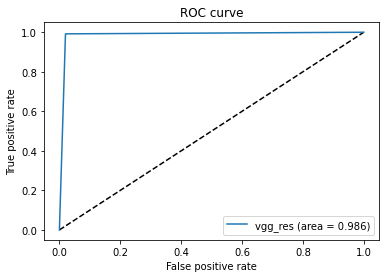

           covid  non-covid
covid        246          5
non-covid      2        244
Classification Report
              precision    recall  f1-score   support

       Covid       0.99      0.98      0.99       251
   Non-covid       0.98      0.99      0.99       246

    accuracy                           0.99       497
   macro avg       0.99      0.99      0.99       497
weighted avg       0.99      0.99      0.99       497



In [104]:
vgg_res = tf.keras.models.load_model('vgg_res_best.h5')

evaluation_vgg_res = vgg_res.evaluate(test_set)
print('Loss: ',evaluation_vgg_res[0])
print('Accuracy: ',evaluation_vgg_res[1])


prob_vgg_res = vgg_res.predict(test_set)
predictions_vgg_res = prob_vgg_res.argmax(axis=-1)
precision_recall_fscore_support(y_true, predictions_vgg_res, average='micro')


fpr_vgg_res, tpr_vgg_res, thresholds_vgg_res = roc_curve(y_true, predictions_vgg_res)
auc_vgg_res = auc(fpr_vgg_res, tpr_vgg_res)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_vgg_res, tpr_vgg_res, label='vgg_res (area = {:.3f})'.format(auc_vgg_res))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


print(pd.DataFrame(data = confusion_matrix(y_true, predictions_vgg_res), index = ['covid', 'non-covid'], columns = ['covid', 'non-covid'] ))
print('Classification Report')
target_names = ['Covid', 'Non-covid']
print(classification_report(y_true, predictions_vgg_res, target_names=target_names))


**VGG16 + Xception**
--

16/16 [==============================] - 3s 178ms/step - loss: 0.0532 - accuracy: 0.9859
Loss:  0.05322690308094025
Accuracy:  0.98591548204422
(0.9859154929577465, 0.9859154929577465, 0.9859154929577465, None)


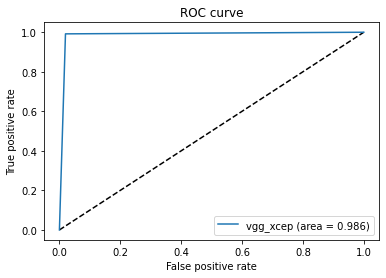

           covid  non-covid
covid        246          5
non-covid      2        244
Classification Report
              precision    recall  f1-score   support

       Covid       0.99      0.98      0.99       251
   Non-covid       0.98      0.99      0.99       246

    accuracy                           0.99       497
   macro avg       0.99      0.99      0.99       497
weighted avg       0.99      0.99      0.99       497



In [105]:
vgg_xcep = tf.keras.models.load_model('vgg_xcep_best.h5')

evaluation_vgg_xcep = vgg_xcep.evaluate(test_set)
print('Loss: ',evaluation_vgg_xcep[0])
print('Accuracy: ',evaluation_vgg_xcep[1])

prob_vgg_xcep = vgg_xcep.predict(test_set)
predictions_vgg_xcep = prob_vgg_xcep.argmax(axis=-1)
print(precision_recall_fscore_support(y_true, predictions_vgg_xcep, average='micro'))

fpr_vgg_xcep, tpr_vgg_xcep, thresholds_vgg_xcep = roc_curve(y_true, predictions_vgg_xcep)
auc_vgg_xcep = auc(fpr_vgg_xcep, tpr_vgg_xcep)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_vgg_xcep, tpr_vgg_xcep, label='vgg_xcep (area = {:.3f})'.format(auc_vgg_xcep))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print(pd.DataFrame(data = confusion_matrix(y_true, predictions_vgg_xcep), index = ['covid', 'non-covid'], columns = ['covid', 'non-covid'] ))
print('Classification Report')
target_names = ['Covid', 'Non-covid']
print(classification_report(y_true, predictions_vgg_xcep, target_names=target_names))

**Xception + ResNet50**
--

16/16 [==============================] - 3s 193ms/step - loss: 0.0965 - accuracy: 0.9618
Loss:  0.09649209678173065
Accuracy:  0.9617705941200256


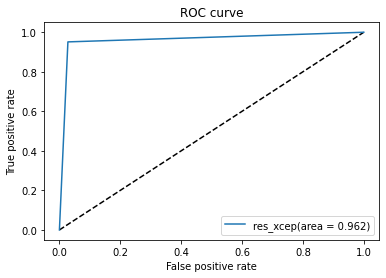

           covid  non-covid
covid        244          7
non-covid     12        234
Classification Report
              precision    recall  f1-score   support

       Covid       0.95      0.97      0.96       251
   Non-covid       0.97      0.95      0.96       246

    accuracy                           0.96       497
   macro avg       0.96      0.96      0.96       497
weighted avg       0.96      0.96      0.96       497



In [106]:
res_xcep = tf.keras.models.load_model('xcep_res_best.h5')

evaluation_res_xcep = res_xcep.evaluate(test_set)
print('Loss: ',evaluation_res_xcep[0])
print('Accuracy: ',evaluation_res_xcep[1])

prob_res_xcep = res_xcep.predict(test_set)
predictions_res_xcep = prob_res_xcep.argmax(axis=-1)
precision_recall_fscore_support(y_true, predictions_res_xcep, average='micro')

fpr_res_xcep, tpr_res_xcep, thresholds_res_xcep = roc_curve(y_true, predictions_res_xcep)
auc_res_xcep = auc(fpr_res_xcep, tpr_res_xcep)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_res_xcep, tpr_res_xcep, label='res_xcep(area = {:.3f})'.format(auc_res_xcep))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print(pd.DataFrame(data = confusion_matrix(y_true, predictions_res_xcep), index = ['covid', 'non-covid'], columns = ['covid', 'non-covid'] ))
print('Classification Report')
target_names = ['Covid', 'Non-covid']
print(classification_report(y_true, predictions_res_xcep, target_names=target_names))



**Stacked(VGG16 + ResNet50 + Xception)**
--

16/16 [==============================] - 3s 189ms/step - loss: 0.0473 - accuracy: 0.9859
Loss:  0.04729397967457771
Accuracy:  0.98591548204422


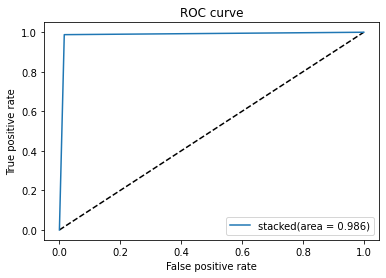

           covid  non-covid
covid        247          4
non-covid      3        243
Classification Report
              precision    recall  f1-score   support

       Covid       0.99      0.98      0.99       251
   Non-covid       0.98      0.99      0.99       246

    accuracy                           0.99       497
   macro avg       0.99      0.99      0.99       497
weighted avg       0.99      0.99      0.99       497



In [107]:
stacked = tf.keras.models.load_model('./stacked_best.h5')

evaluation_stacked = stacked.evaluate(test_set)
print('Loss: ',evaluation_stacked[0])
print('Accuracy: ',evaluation_stacked[1])

prob_stacked = stacked.predict(test_set)
predictions_stacked = prob_stacked.argmax(axis=-1)
precision_recall_fscore_support(y_true, predictions_stacked, average='micro')

fpr_stacked, tpr_stacked, thresholds_stacked = roc_curve(y_true, predictions_stacked)
auc_stacked = auc(fpr_stacked, tpr_stacked)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_stacked, tpr_stacked, label='stacked(area = {:.3f})'.format(auc_stacked))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print(pd.DataFrame(data = confusion_matrix(y_true, predictions_stacked), index = ['covid', 'non-covid'], columns = ['covid', 'non-covid'] ))
print('Classification Report')
target_names = ['Covid', 'Non-covid']
print(classification_report(y_true, predictions_stacked, target_names=target_names))

**ROC of Stacked vs Individuals**
--

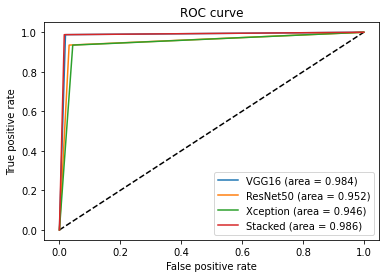

In [108]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_vgg, tpr_vgg, label='VGG16 (area = {:.3f})'.format(auc_vgg))
plt.plot(fpr_res, tpr_res, label='ResNet50 (area = {:.3f})'.format(auc_res))
plt.plot(fpr_xcep, tpr_xcep, label='Xception (area = {:.3f})'.format(auc_xcep))
plt.plot(fpr_stacked, tpr_stacked, label='Stacked (area = {:.3f})'.format(auc_stacked))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

**ROC of Ensembles**
--

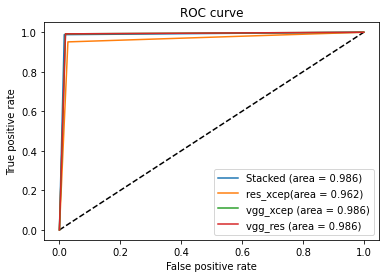

In [109]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_stacked, tpr_stacked, label='Stacked (area = {:.3f})'.format(auc_stacked))
plt.plot(fpr_res_xcep, tpr_res_xcep, label='res_xcep(area = {:.3f})'.format(auc_res_xcep))
plt.plot(fpr_vgg_xcep, tpr_vgg_xcep, label='vgg_xcep (area = {:.3f})'.format(auc_vgg_xcep))
plt.plot(fpr_vgg_res, tpr_vgg_res, label='vgg_res (area = {:.3f})'.format(auc_vgg_res))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()